## Kalman Filter Algorithm

The algorithm is the same Bayesian filter algorithm that we have used in every chapter. The update step is slightly more complicated, but I will explain why when we get to it.

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based
    on scaling factor
    5. update belief in the state based on how certain we are
    in the measurement

Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

Read file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/finaldatasets.csv')
df.head()

,Time,Rainfall,Temperature,Humidity,Cases
0,2016-w1,0.034,28.100000,81.671429,19
1,2016-w2,0.000,28.310000,81.685714,23
2,2016-w3,0.000,28.033333,80.400000,31
3,2016-w4,0.420,26.527778,85.985714,26
4,2016-w5,5.660,27.444440,84.680000,10


Convert Time to proper date format

In [ ]:
# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'] + '-1', format='%Y-w%W-%w')

*Prepare the data*

In [ ]:
y = df['Cases'].values  # Dependent variable (cases)
X = df[['Rainfall', 'Temperature', 'Humidity']].values  # Regressors

 Split data into 80% train and 20% test


In [ ]:
train_size = int(len(df) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

 Add intercept (column of ones) to the observation matrix for training and Reshape to be compatible with Kalman Filter (n_timesteps, 1, n_regressors + 1)


In [ ]:
n_timesteps_train, n_regressors = X_train.shape
observation_matrices_train = np.array([np.concatenate(([1], X_train[i])) for i in range(n_timesteps_train)])
observation_matrices_train = observation_matrices_train.reshape((n_timesteps_train, 1, n_regressors + 1))

print(observation_matrices_train[:10])
print(observation_matrices_train.shape)

[[[1.00000000e+00 3.40000000e-02 2.81000000e+01 8.16714286e+01]]

 [[1.00000000e+00 0.00000000e+00 2.83100000e+01 8.16857143e+01]]

 [[1.00000000e+00 0.00000000e+00 2.80333330e+01 8.04000000e+01]]

 [[1.00000000e+00 4.20000000e-01 2.65277780e+01 8.59857143e+01]]

 [[1.00000000e+00 5.66000000e+00 2.74444400e+01 8.46800000e+01]]

 [[1.00000000e+00 1.90000000e-01 2.62833330e+01 8.35142857e+01]]

 [[1.00000000e+00 1.40000000e-01 2.69833330e+01 8.29714286e+01]]

 [[1.00000000e+00 1.10000000e-01 2.64944440e+01 8.20857143e+01]]

 [[1.00000000e+00 6.40000000e-02 2.77722220e+01 8.31714286e+01]]

 [[1.00000000e+00 0.00000000e+00 2.85444440e+01 8.05714286e+01]]]
(320, 1, 4)


Define the Kalman Filter

In [ ]:
# Set initial state mean and covariance
initial_state_mean = np.zeros(n_regressors + 1)  # State for intercept and coefficients
initial_state_covariance = np.eye(n_regressors + 1)  # Identity matrix

kf = KalmanFilter(
    transition_matrices=np.eye(n_regressors + 1),  # State transition matrix (identity for now)
    observation_matrices=observation_matrices_train,  # Observation matrix with intercept and regressors
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=1.0,  # Measurement noise
    transition_covariance=0.01 * np.eye(n_regressors + 1)  # State transition noise
)

Train the Kalman Filter on the training set and Predict on the test set using the state means from training

In [ ]:
# Train the Kalman Filter on the training set
state_means_train, state_covariances_train = kf.em(y_train, n_iter=10).smooth(y_train)

# Add intercept (column of ones) to the observation matrix for testing
n_timesteps_test = X_test.shape[0]
observation_matrices_test = np.array([np.concatenate(([1], X_test[i])) for i in range(n_timesteps_test)])
observation_matrices_test = observation_matrices_test.reshape((n_timesteps_test, 1, n_regressors + 1))

predicted_cases_test = np.dot(observation_matrices_test.squeeze(), state_means_train.T).diagonal()

Actual vs predicted cases

In [ ]:
results_df = pd.DataFrame({
    'Actual Cases': y_test,
    'Forecasted Cases': predicted_cases_test
})

# Print the DataFrame
print(results_df)

# Optionally, print the first 10 rows to limit the output
print("\nFirst 10 rows of Actual vs Forecasted Cases:\n", results_df.head(10))


    Actual Cases  Forecasted Cases
0              6         17.110319
1              8         21.655977
2             15         30.253811
3             11         27.665669
4             12         17.460815
..           ...               ...
75           226         -1.390072
76           205          2.004026
77           209          3.765426
78           162          6.907065
79           103         11.912610

[80 rows x 2 columns]

First 10 rows of Actual vs Forecasted Cases:
    Actual Cases  Forecasted Cases
0             6         17.110319
1             8         21.655977
2            15         30.253811
3            11         27.665669
4            12         17.460815
5            11         14.715796
6            11         12.492557
7            15         21.872725
8            17         14.909968
9            15         14.065188


Display visualition for actual vs predicted cases

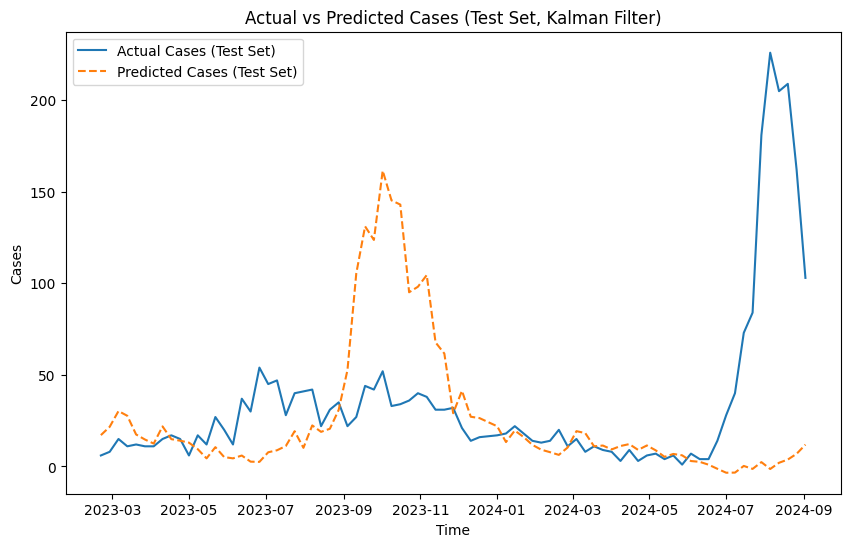

In [ ]:
# Plot actual vs predicted cases for test set
plt.figure(figsize=(10, 6))
plt.plot(df['Time'][train_size:], y_test, label='Actual Cases (Test Set)')
plt.plot(df['Time'][train_size:], predicted_cases_test, label='Predicted Cases (Test Set)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.title('Actual vs Predicted Cases (Test Set, Kalman Filter)')
plt.show()

Evaluate the Kalman Filter performance


In [ ]:
mse = mean_squared_error(y_test, predicted_cases_test)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

# To compute classification metrics (Accuracy, Precision, Recall), we need to binarize the data
threshold = y_train.mean()  # Simple threshold based on the training set mean
y_test_class = (y_test >= threshold).astype(int)
predicted_cases_test_class = (predicted_cases_test >= threshold).astype(int)

# Calculate classification metrics
accuracy = accuracy_score(y_test_class, predicted_cases_test_class)
precision = precision_score(y_test_class, predicted_cases_test_class)
recall = recall_score(y_test_class, predicted_cases_test_class)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Mean Squared Error (MSE): 3735.2507454172287
Root Mean Squared Error (RMSE): 61.116698
Accuracy: 0.6625
Precision: 0.6842105263157895
Recall: 0.38235294117647056
